<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_10_CNN_Keras_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задля запобіганню втрати часу рекомендую підгрузити вкладені збережені та навчені моделі і робити тестування вже на них.

В аттачі архів, файли з якого треба достати у корінь проекту.
Навчання було виконано в докер контейнері на особистій машині, час виконання в колабі захмарний

# Домашнє завдання
Частина 1

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

## Імпорти та завантаження датасету

In [ ]:
!pip install wandb


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install keras-tuner


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install scikit-image



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import math
import numpy as np
import os
import random
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import UpSampling2D
from keras.models import load_model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from keras_tuner.tuners import RandomSearch

import wandb
from wandb.keras import WandbMetricsLogger

2023-08-13 06:24:33.341983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 06:24:33.391191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 06:24:33.392131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 06:24:34.532225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
path = "." #"/content/drive/MyDrive/Colab Notebooks/HW_10_data"

## Підключимо незалежний монітор для тривалого збіру аналітики

In [ ]:
# Задамо константи і може в подальшому реалізуємо підбір
num_classes = 10
# num_features = 28 * 28

lr = 0.001
n_epochs = 15
batch_size = 256
validation_split = 0.2

In [ ]:
wandb.init(project="HW_10_cnn_keras_fashion_mnist+VGG16", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

wandb: Currently logged in as: 4751413. Use `wandb login --relogin` to force relogin


## Короткий огляд змісту, підготовка даних для нейромережі

In [ ]:
# Завантажимо датасет fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# Розділення тестових даних на тестовий та валідаційний набори
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=validation_split, random_state=42)

In [ ]:
# Подивимося розміри
train_images.shape, train_labels.shape

((48000, 28, 28), (48000,))

In [ ]:
val_images.shape, val_labels.shape

((12000, 28, 28), (12000,))

In [ ]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [ ]:
test_labels[0]

9

In [ ]:
# Підготуємо словник для візуалізацій
labels = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
labels2index = {i: item for i, item in enumerate(labels)}

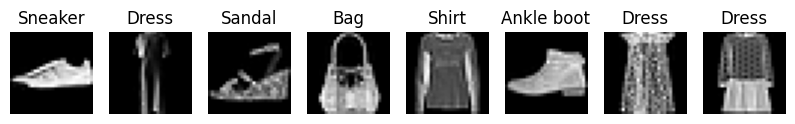

In [ ]:
# Візуалізуємо декілька зображень та їх міток
def visualize_images(images, labels, labels2index, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels2index[labels[i]])
        plt.axis('off')
    plt.show()

num_images_to_visualize = 8
visualize_images(train_images, train_labels, labels2index, num_images=num_images_to_visualize)

### Підготуємо дані для моделі

In [ ]:
# Переведемо дані зображень в діапазон [0, 1]
train_images = train_images.astype('float32') / 255
val_images = val_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Перетворимо мітки класів у one-hot кодування
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [ ]:
train_images.shape, val_images.shape, test_images.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

In [ ]:
train_labels.shape, val_labels.shape, test_labels.shape

((48000, 10), (12000, 10), (10000, 10))

In [ ]:
# Створимо генератори даних одразу для обох моделей

def create_data_generators(train_data, train_labels, val_data, val_labels, test_data, test_labels, data_gen_params, batch_size):
    train_datagen = ImageDataGenerator(**data_gen_params)
    val_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
    val_generator = val_datagen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)
    test_generator = test_datagen.flow(test_data, test_labels, batch_size=batch_size, shuffle=False)

    return train_generator, val_generator, test_generator

In [ ]:
# Загальні параметри для звичайної CNN (28x28 з одним каналом)
data_gen_params = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}

# Розширення розмірності даних
train_images_expanded = np.expand_dims(train_images, axis=-1)
val_images_expanded = np.expand_dims(val_images, axis=-1)
test_images_expanded = np.expand_dims(test_images, axis=-1)

# Створення генераторів для першої моделі
train_generator_simple, val_generator_simple, test_generator_simple = create_data_generators(train_images_expanded, train_labels, val_images_expanded, val_labels, test_images_expanded, test_labels, data_gen_params, batch_size)

Перевіримо що видають генератори

In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(train_generator_simple)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 28, 28, 1)
Розмір міток класів: (256, 10)


In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(val_generator_simple)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 28, 28, 1)
Розмір міток класів: (256, 10)


In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(test_generator_simple)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 28, 28, 1)
Розмір міток класів: (256, 10)


Перевіримо нормалізацію пікселів

In [ ]:
print("Мінімальне значення пікселя:", np.min(x_batch))
print("Максимальне значення пікселя:", np.max(x_batch))

Мінімальне значення пікселя: 0.0
Максимальне значення пікселя: 1.0


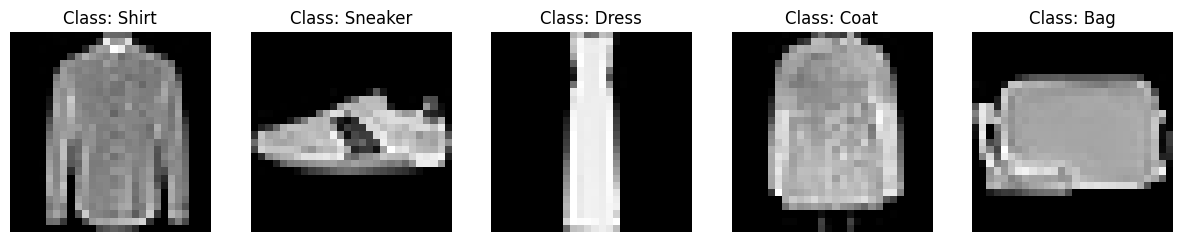

In [ ]:
# Візуалізація перших 5 зображень з батчу
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i].reshape(28, 28), cmap='gray')
    class_index = y_batch[i].argmax()
    class_label = labels2index[class_index]
    plt.title(f"Class: {class_label}")
    plt.axis('off')
plt.show()

In [ ]:
# Загальні параметри для CNN на основі VGG16 (32x32 з трьома каналами)
data_gen_params_vgg = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}


# Збільшення розміру зображень до 32x32
new_size = (32, 32)
train_images_32x32 = tf.image.resize(np.array(train_images)[..., tf.newaxis], new_size)
val_images_32x32 = tf.image.resize(np.array(val_images)[..., tf.newaxis], new_size)
test_images_32x32 = tf.image.resize(np.array(test_images)[..., tf.newaxis], new_size)

# Збільшення каналів до трьох
train_images_32x32 = np.repeat(train_images_32x32, 3, axis=-1)
val_images_32x32 = np.repeat(val_images_32x32, 3, axis=-1)
test_images_32x32 = np.repeat(test_images_32x32, 3, axis=-1)




# Створення генераторів для моделі на основі VGG16
train_generator_vgg, val_generator_vgg, test_generator_vgg = create_data_generators(
    train_images_32x32, train_labels,
    val_images_32x32, val_labels,
    test_images_32x32, test_labels,
    data_gen_params_vgg, batch_size)


Перевіримо роботу генераторів

In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(train_generator_vgg)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 32, 32, 3)
Розмір міток класів: (256, 10)


In [ ]:
print("Мінімальне значення пікселя:", np.min(x_batch))
print("Максимальне значення пікселя:", np.max(x_batch))

Мінімальне значення пікселя: 0.0
Максимальне значення пікселя: 0.9982915


In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(val_generator_vgg)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 32, 32, 3)
Розмір міток класів: (256, 10)


In [ ]:
print("Мінімальне значення пікселя:", np.min(x_batch))
print("Максимальне значення пікселя:", np.max(x_batch))

Мінімальне значення пікселя: 0.0
Максимальне значення пікселя: 1.0


In [ ]:
# Отримання наступного партії даних з генератора
x_batch, y_batch = next(test_generator_vgg)

# Виведення розмірів партії даних
print("Розмір вхідних даних:", x_batch.shape)
print("Розмір міток класів:", y_batch.shape)

Розмір вхідних даних: (256, 32, 32, 3)
Розмір міток класів: (256, 10)


In [ ]:
print("Мінімальне значення пікселя:", np.min(x_batch))
print("Максимальне значення пікселя:", np.max(x_batch))

Мінімальне значення пікселя: 0.0
Максимальне значення пікселя: 1.0


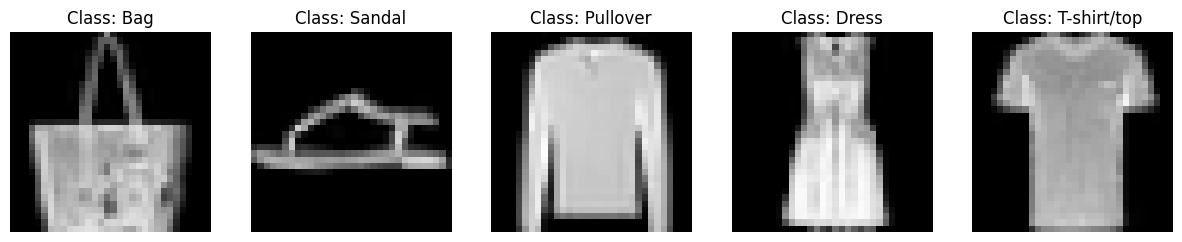

In [ ]:
# Візуалізація перших 5 зображень з батчу
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    class_index = y_batch[i].argmax()
    class_label = labels2index[class_index]
    plt.title(f"Class: {class_label}")
    plt.axis('off')
plt.show()

# Реалізуємо нейромережу та навчимо її

In [ ]:
# Додамо колбек EarlyStopping, щоб зупинити навчання, якщо точність не покращується протягом певної кількості епох
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Додамо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)



In [ ]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

## Regular way

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
history = model.fit(
    train_generator_simple,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=val_generator_simple,
    callbacks=callbacks
)

Epoch 1/15
188/188 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.6214
Epoch 1: val_accuracy improved from -inf to 0.77192, saving model to ./best_model.h5
188/188 [==============================] - 27s 139ms/step - loss: 1.0376 - accuracy: 0.6214 - val_loss: 0.5870 - val_accuracy: 0.7719
Epoch 2/15


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.7271
Epoch 2: val_accuracy improved from 0.77192 to 0.79467, saving model to ./best_model.h5
188/188 [==============================] - 26s 138ms/step - loss: 0.7189 - accuracy: 0.7271 - val_loss: 0.5293 - val_accuracy: 0.7947
Epoch 3/15
188/188 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.7569
Epoch 3: val_accuracy improved from 0.79467 to 0.81775, saving model to ./best_model.h5
188/188 [==============================] - 26s 141ms/step - loss: 0.6422 - accuracy: 0.7569 - val_loss: 0.4987 - val_accuracy: 0.8177
Epoch 4/15
188/188 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.7740
Epoch 4: val_accuracy improved from 0.81775 to 0.83358, saving model to ./best_model.h5
188/188 [==============================] - 26s 140ms/step - loss: 0.5995 - accuracy: 0.7740 - val_loss: 0.4409 - val_accuracy: 0.8336
Epoch 5/15
188/188 [==============================] - ETA

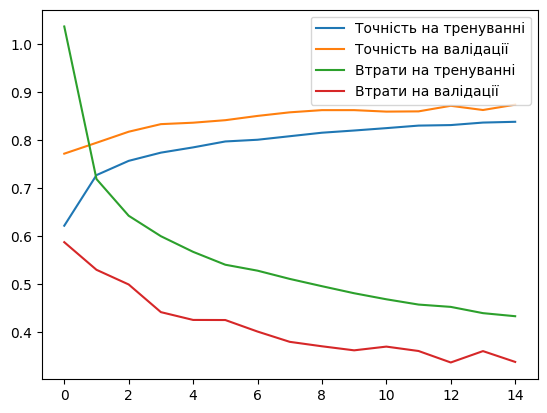

In [ ]:
# Графіки для точності та втрат
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [ ]:
# Завантаження кращої збереженої моделі
best_model = load_model(path+'/best_model.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model.evaluate(test_generator_simple)

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

40/40 [==============================] - 1s 22ms/step - loss: 0.3474 - accuracy: 0.8720
Втрати на тестовому наборі: 0.3474
Точність на тестовому наборі: 0.8720


## Суб висновок: - валідаційні дані проходять з кращими показниками. Поки що  накращій - 0,874 на валідації, час 3 хвилини, на тесті - 0,872. n_epoch=15;  lr=0,001; b=256 Trainable params: 225 034


## Keras tuner

In [ ]:
# Побудуємо архітектуру мережі:
def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
                     activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner_cnn = RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=5,
    directory=path+'/keras_tuner_dir',
    project_name='fashion_mnist_cnn_tuning'
)


INFO:tensorflow:Reloading Tuner from ./keras_tuner_dir/fashion_mnist_cnn_tuning/tuner0.json


In [ ]:
tuner_cnn.search(train_generator_simple,
                 epochs=n_epochs,
                 validation_data=val_generator_simple,
                 batch_size=batch_size,)
                 #callbacks=callbacks)

tuner_cnn.results_summary()

INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner_dir/fashion_mnist_cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
conv1_filters: 80
conv1_kernel: 5
conv2_filters: 192
conv2_kernel: 3
dense_units: 480
dropout: 0.2
learning_rate: 0.001
Score: 0.8756666779518127

Trial 1 summary
Hyperparameters:
conv1_filters: 128
conv1_kernel: 3
conv2_filters: 256
conv2_kernel: 3
dense_units: 256
dropout: 0.2
learning_rate: 0.001
Score: 0.8693333268165588

Trial 3 summary
Hyperparameters:
conv1_filters: 128
conv1_kernel: 3
conv2_filters: 96
conv2_kernel: 3
dense_units: 256
dropout: 0.2
learning_rate: 0.001
Score: 0.8585833311080933

Trial 0 summary
Hyperparameters:
conv1_filters: 112
conv1_kernel: 5
conv2_filters: 32
conv2_kernel: 3
dense_units: 320
dropout: 0.4
learning_rate: 0.01
Score: 0.8371666669845581

Trial 4 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 5
conv2_filters: 64
conv2_kernel: 5

In [ ]:
# Змінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/best_model_tuned.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
# Отримання найкращої моделі
best_model_cnn_tuned = tuner_cnn.get_best_models(num_models=1)[0]

In [ ]:
best_model_cnn_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 80)        2080      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 192)       138432    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 192)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 480)               2

In [ ]:
# Навчання найкращої моделі
history_tuned = best_model_cnn_tuned.fit(
    train_generator_simple,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=val_generator_simple,
    callbacks=callbacks)

Epoch 1/15
188/188 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8440
Epoch 1: val_accuracy improved from -inf to 0.88058, saving model to ./best_model_tuned.h5
188/188 [==============================] - 57s 300ms/step - loss: 0.4106 - accuracy: 0.8440 - val_loss: 0.3207 - val_accuracy: 0.8806
Epoch 2/15
188/188 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8539
Epoch 2: val_accuracy improved from 0.88058 to 0.88725, saving model to ./best_model_tuned.h5
188/188 [==============================] - 60s 317ms/step - loss: 0.3918 - accuracy: 0.8539 - val_loss: 0.3038 - val_accuracy: 0.8873
Epoch 3/15
188/188 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8567
Epoch 3: val_accuracy did not improve from 0.88725
188/188 [==============================] - 63s 336ms/step - loss: 0.3777 - accuracy: 0.8567 - val_loss: 0.3100 - val_accuracy: 0.8867
Epoch 4/15
188/188 [==============================] - ETA: 0s - loss: 0.37

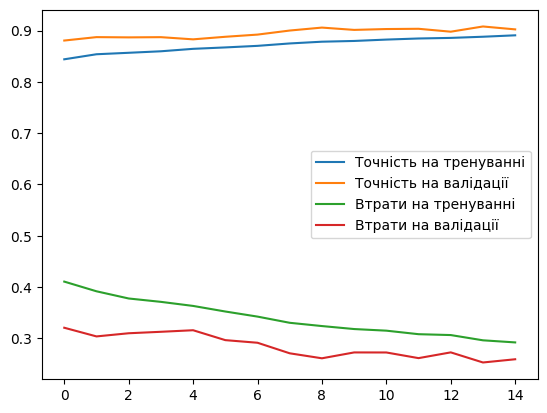

In [ ]:
# Графіки для точності та втрат
plt.plot(history_tuned.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_tuned.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_tuned.history['loss'], label='Втрати на тренуванні')
plt.plot(history_tuned.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [ ]:
# Оцінимо найкращу модель на тестовому наборі даних
test_loss_tuned, test_accuracy_tuned = best_model_cnn_tuned.evaluate(test_generator_simple)
print(f'Точність на тестовому наборі: {test_accuracy_tuned}')

40/40 [==============================] - 3s 74ms/step - loss: 0.2747 - accuracy: 0.8985
Точність на тестовому наборі: 0.8985000252723694


In [ ]:
# Збереження найкращої знайденої моделі на диск
best_model_cnn_tuned.save(path+'/best_model_cnn_tuned.h5')

In [ ]:
# Завантаження моделі з диску
loaded_model = load_model(path+'/best_model_cnn_tuned.h5')

In [ ]:
# Оцінка моделі на тестовому наборі даних
test_loss_loaded, test_accuracy_loaded = loaded_model.evaluate(test_generator_simple)
print(f'Точність моделі після завантаження: {test_accuracy_loaded}')

40/40 [==============================] - 3s 71ms/step - loss: 0.2747 - accuracy: 0.8985
Точність моделі після завантаження: 0.8985000252723694


## Суб висновок: доволи довго триває підбір параметрів в перший раз, але потім зі збереженої теки дуже швидко формує параметри. Поки що накращій - 0.908 на валідації, на тесті - 0,898, час на 15 епохах - біля 18 хвилин. Перенавчення не спостерігається, але можна було б і краще. Trainable params: 2 449 802

## Проведемо роботу над помилками

313/313 [==============================] - 3s 11ms/step


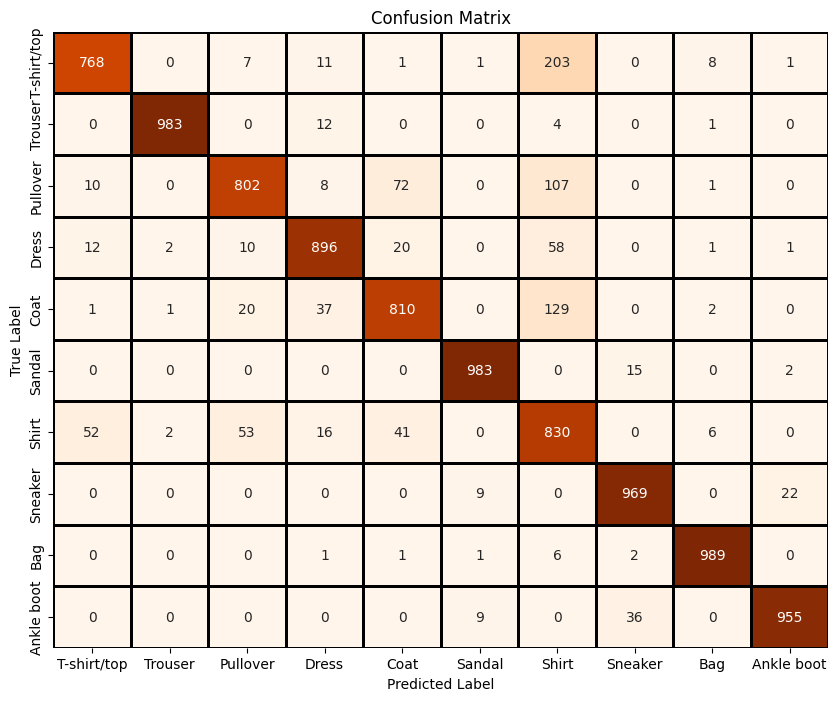

In [ ]:
# Побудуємо confusion_matrix
predictions = loaded_model.predict(test_images.reshape(-1, 28, 28, 1))
predicted_labels = np.argmax(predictions, axis=1)

confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, predicted_label in zip(np.argmax(test_labels, axis=1), predicted_labels):
    confusion_matrix[true_label, predicted_label] += 1

# Відобразимо heatmap confusion_matrix з seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,  fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

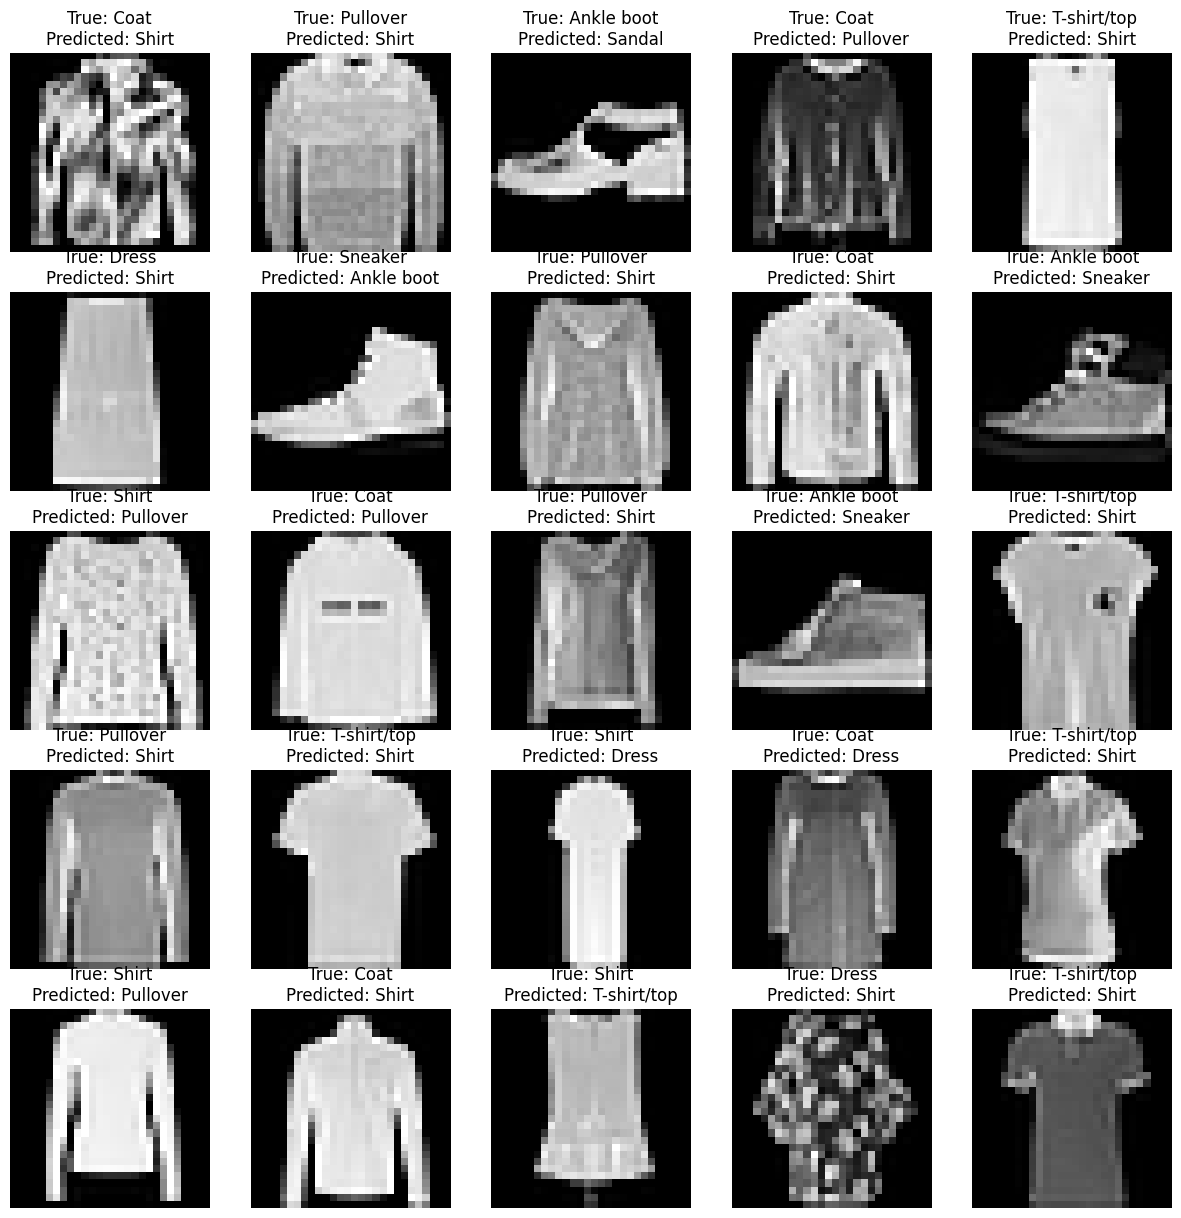

In [ ]:
# Знайдемо невірно класифіковані зображення
incorrect_indices = np.where(predicted_labels != np.argmax(test_labels, axis=1))[0]

# Виведемо графік 5x5 зображень невірно класифікованих зображень разом з мітками
plt.figure(figsize=(15, 15))
for i, idx in enumerate(incorrect_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx].reshape((28, 28)), cmap='gray')
    plt.title('True: {}\nPredicted: {}'.format(labels[np.argmax(test_labels[idx])], labels[predicted_labels[idx]]))
    plt.axis('off')
plt.show()

In [ ]:
# Загальна кількість невлучних передбачень
incorrect_indices.shape

(1015,)

## Частина 2
В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
# Завантаження передньо навченої моделі VGG16 без верхнього класифікаційного шару
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Розблокування лише шару block5_conv1 для навчання
for layer in base_model.layers:
    if layer.name == 'block5_conv1':  # 'block5_conv3'
        layer.trainable = True
    else:
        layer.trainable = False


# Створюємо модель, об'єднуючи базову модель та власний класифікаційний шар

model_vgg16 = Sequential([
   base_model,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(num_classes, activation="softmax"),
])

In [ ]:
# Компілюємо модель
model_vgg16.compile(optimizer=RMSprop(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Виводимо структуру моделі
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 2493706 (9.51 MB)
Non-trainable params: 12354880 (47.13 MB)
_________________________________________________________________


In [ ]:
# Змінимо колбеки, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/best_model_with_vgg16.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [ ]:
# Навчання моделі на основі VGG16
history_vgg16 = model_vgg16.fit(
    train_generator_vgg,
    epochs=n_epochs,
    validation_data=val_generator_vgg,
    callbacks=callbacks,
)

Epoch 1/15
188/188 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.8194
Epoch 1: val_accuracy improved from -inf to 0.83242, saving model to ./best_model_with_vgg16.h5
188/188 [==============================] - 740s 4s/step - loss: 0.4722 - accuracy: 0.8194 - val_loss: 0.4314 - val_accuracy: 0.8324
Epoch 2/15
188/188 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.8347
Epoch 2: val_accuracy did not improve from 0.83242
188/188 [==============================] - 721s 4s/step - loss: 0.4328 - accuracy: 0.8347 - val_loss: 0.4670 - val_accuracy: 0.8219
Epoch 3/15
188/188 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.8432
Epoch 3: val_accuracy improved from 0.83242 to 0.85767, saving model to ./best_model_with_vgg16.h5
188/188 [==============================] - 814s 4s/step - loss: 0.4130 - accuracy: 0.8432 - val_loss: 0.3697 - val_accuracy: 0.8577
Epoch 4/15
188/188 [==============================] - ETA: 0s - loss: 

In [ ]:
test_loss, test_acc = model_vgg16.evaluate(test_generator_vgg, verbose=1)
print("\nТочність на тестових даних:", test_acc)

40/40 [==============================] - 48s 1s/step - loss: 0.3435 - accuracy: 0.8756

Точність на тестових даних: 0.8755999803543091


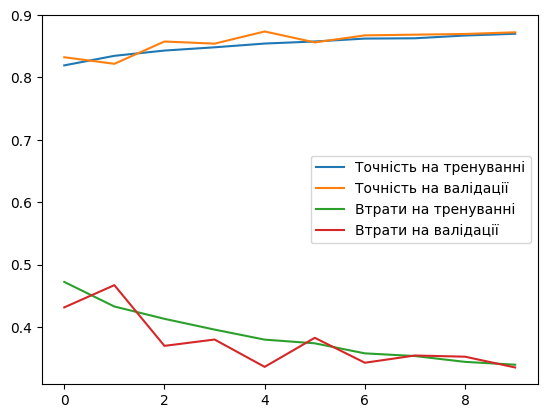

In [ ]:
# Графіки для точності та втрат
plt.plot(history_vgg16.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_vgg16.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_vgg16.history['loss'], label='Втрати на тренуванні')
plt.plot(history_vgg16.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [ ]:
# Завантаження моделі з диску
loaded_model = load_model(path+'/best_model_with_vgg16.h5')

In [ ]:
test_loss_loaded, test_accuracy_loaded = loaded_model.evaluate(test_generator_vgg)
print(f'Точність моделі після завантаження: {test_accuracy_loaded}')

40/40 [==============================] - 47s 1s/step - loss: 0.3428 - accuracy: 0.8748
Точність моделі після завантаження: 0.8748000264167786


## Суб висновок - дууже довго,  з розблокованим  CNN шаром -  - block5_conv1 Trainable params: 2 493 706 : тренування - 0,874, тест - 0,876, 15 епох - 150 хвилин

# Висновки:
За 15 епох:
Побудована нейромережа після підбору параметрів видає точність в діапазоні 87,2% на тестових даних.

Альтернативна нейромережа (kerastuner) видає 89,8% на тестових даних, але в 6 раз довше ніж перша.

Мережа побудована на vgg16 видає 87,6% на тестових з розблокованим нижнім шаром - block5_conv1, але в 25 раз довше ніж перша модель.

Найкращою у співвідношенні точність/витрачений на навчання час виявилася модель, яка за допомогою утіліти kerastuner підібрала параметри, модель побудована на vgg16 не виправдала очікувань (але можливо є помилка у підготовці даних або інші користувацькі помилки за браком досвіду)